In [1]:
from pennylane import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
sys.path.insert(0, '/Users/tak/Github/QEmbedding/')
import Hybrid_nn
import torch
from torch import nn
import data
import pennylane as qml
import embedding

# Trace distance History (Embedding Training)

In [2]:
PATHs_Model2, PATHs_Model3 = [], []

for i in range(49):
    PATH_Model2 = f'/Users/tak/Github/QEmbedding/Results/QCNN_demonstration/Real device/Real/Model2 pre-train/Model2_{i}.pt'
    PATH_Model3 = f'/Users/tak/Github/QEmbedding/Results/QCNN_demonstration/Real device/Real/Model3 pre-train/Model3_{i}.pt'

    PATHs_Model2.append(PATH_Model2)
    PATHs_Model3.append(PATH_Model3)

In [3]:
dev_sim = qml.device('default.qubit', wires=4)
@qml.qnode(dev_sim, interface="torch")
def Noisy_Distance(inputs): 
    embedding.Noisy_Four_QuantumEmbedding2(inputs)
    return qml.density_matrix(wires=range(4))

class Distances2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer2 = qml.qnn.TorchLayer(Noisy_Distance, weight_shapes={})
        self.linear_relu_stack2 = nn.Sequential(
            nn.Linear(4, 12),
            nn.ReLU(),
            nn.Linear(12, 12),
            nn.ReLU(),
            nn.Linear(12, 7)
        )
    def forward(self, x1, x0):
        x1 = self.linear_relu_stack2(x1)
        x0 = self.linear_relu_stack2(x0)
        rhos1 = self.qlayer2(x1)
        rhos0 = self.qlayer2(x0)

        rho1 = torch.sum(rhos1, dim=0) / len(x1)
        rho0 = torch.sum(rhos0, dim=0) / len(x0)
        rho_diff = rho1 - rho0
        eigvals = torch.linalg.eigvals(rho_diff)
        return 0.5 * torch.real(torch.sum(torch.abs(eigvals)))


class Distances3(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer3 = qml.qnn.TorchLayer(Noisy_Distance, weight_shapes={})
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Layer2: 14 * 14 -> 7 * 7
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected Layers 7 * 7 -> 7
        self.fc = torch.nn.Linear(7 * 7, 7, bias=True)
    
    def forward(self, x1, x0):
        x1 = self.layer1(x1)
        x1 = self.layer2(x1)
        x1 = x1.view(-1, 7 * 7)
        x1 = self.fc(x1)

        x0 = self.layer1(x0)
        x0 = self.layer2(x0)
        x0 = x0.view(-1, 7 * 7)
        x0 = self.fc(x0)

        rhos1 = self.qlayer3(x1)
        rhos0 = self.qlayer3(x0)
        
        rho1 = torch.sum(rhos1, dim=0) / len(x1)
        rho0 = torch.sum(rhos0, dim=0) / len(x0)
        rho_diff = rho1 - rho0
        eigvals = torch.linalg.eigvals(rho_diff)
        return 0.5 * torch.real(torch.sum(torch.abs(eigvals)))

# Calculated from Model1 
Trace_before_traindata = 0.2734867334365845
Trace_before_testdata = 0.2723434865474701

In [4]:
def D(PATH, Model, X1, X0):
    if Model == 'Model2':
        Distance = Distances2()
    elif Model == 'Model3':
        Distance = Distances3()
    
    Distance.load_state_dict(torch.load(PATH))
    return Distance(X1, X0)

Model 2

In [5]:
feature_reduction = 'PCA4'
classes = [0,1]
X_train, X_test, Y_train, Y_test = data.data_load_and_process('mnist', feature_reduction=feature_reduction, classes=classes)

X1_test, X0_test = [], []
for i in range(len(X_test)):
    if Y_test[i] == 1:
        X1_test.append(X_test[i])
    else:
        X0_test.append(X_test[i])
X1_test, X0_test = torch.tensor(X1_test).to(torch.float32), torch.tensor(X0_test).to(torch.float32)

X1_train, X0_train = [], []
for i in range(len(X_train)):
    if Y_train[i] == 1:
        X1_train.append(X_train[i])
    else:
        X0_train.append(X_train[i])
X1_train, X0_train = torch.tensor(X1_train).to(torch.float32), torch.tensor(X0_train).to(torch.float32)

/var/folders/ym/ry24dhs911s7zbqfbhs5ns2m0000gn/T/ipykernel_1760/3063670933.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525498485/work/torch/csrc/utils/tensor_new.cpp:233.)
  X1_test, X0_test = torch.tensor(X1_test).to(torch.float32), torch.tensor(X0_test).to(torch.float32)


In [6]:
Trace_Distance_history_Model2_Train = [D(PATH=p, Model='Model2', X1=X1_train, X0=X0_train).detach().numpy() for p in PATHs_Model2]
Trace_Distance_history_Model2_Test = [D(PATH=p, Model='Model2', X1=X1_test, X0=X0_test).detach().numpy() for p in PATHs_Model2]

/Users/tak/miniforge3/envs/QC/lib/python3.10/site-packages/pennylane/qnn/torch.py:328: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525498485/work/aten/src/ATen/native/Copy.cpp:250.)
  return self.qnode(**kwargs).type(x.dtype)


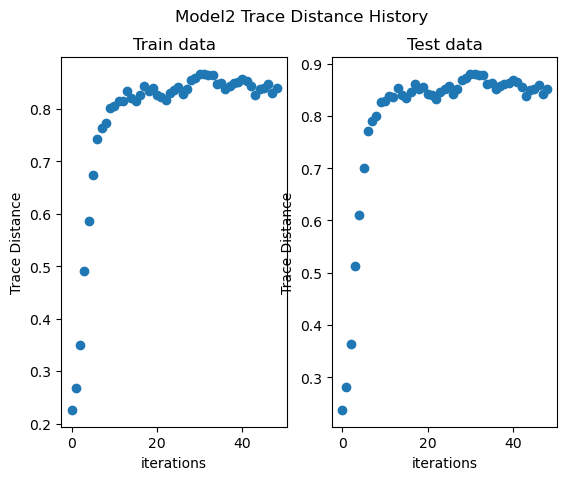

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Model2 Trace Distance History')
plt.rcParams['figure.figsize'] = [2, 10]
ax1.scatter(range(49), Trace_Distance_history_Model2_Train)
ax2.scatter(range(49), Trace_Distance_history_Model2_Test)
ax1.set_xlabel('iterations')
ax2.set_xlabel('iterations')
ax1.set_ylabel('Trace Distance')
ax2.set_ylabel('Trace Distance')
ax1.set_title('Train data')
ax2.set_title('Test data')
plt.show()

Model 3

In [8]:
feature_reduction = False
classes = [0,1]
X_train, X_test, Y_train, Y_test = data.data_load_and_process('mnist', feature_reduction=feature_reduction, classes=classes)

X1_test, X0_test = [], []
for i in range(len(X_test)):
    if Y_test[i] == 1:
        X1_test.append(X_test[i])
    else:
        X0_test.append(X_test[i])
X1_test, X0_test = torch.tensor(X1_test).to(torch.float32), torch.tensor(X0_test).to(torch.float32)
X1_test, X0_test = X1_test.permute(0, 3, 1, 2), X0_test.permute(0, 3, 1, 2)

X1_train, X0_train = [], []
for i in range(len(X_train)):
    if Y_train[i] == 1:
        X1_train.append(X_train[i])
    else:
        X0_train.append(X_train[i])
X1_train, X0_train = torch.tensor(X1_train).to(torch.float32), torch.tensor(X0_train).to(torch.float32)
X1_train, X0_train = X1_train.permute(0, 3, 1, 2), X0_train.permute(0, 3, 1, 2)

In [9]:
Trace_Distance_history_Model3_Train = [D(PATH=p, Model='Model3', X1=X1_train, X0=X0_train).detach().numpy() for p in PATHs_Model3]
Trace_Distance_history_Model3_Test = [D(PATH=p, Model='Model3', X1=X1_test, X0=X0_test).detach().numpy() for p in PATHs_Model3]

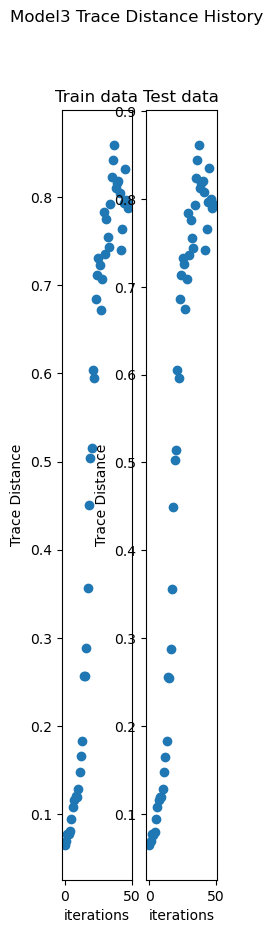

In [10]:
fig2, (ax1, ax2) = plt.subplots(1, 2)
plt.rcParams['figure.figsize'] = [2, 10]
fig2.suptitle('Model3 Trace Distance History')
ax1.scatter(range(49), Trace_Distance_history_Model3_Train)
ax2.scatter(range(49), Trace_Distance_history_Model3_Test)
ax1.set_xlabel('iterations')
ax2.set_xlabel('iterations')
ax1.set_ylabel('Trace Distance')
ax2.set_ylabel('Trace Distance')
ax1.set_title('Train data')
ax2.set_title('Test data')
plt.show()